# Academia

### Diagrama

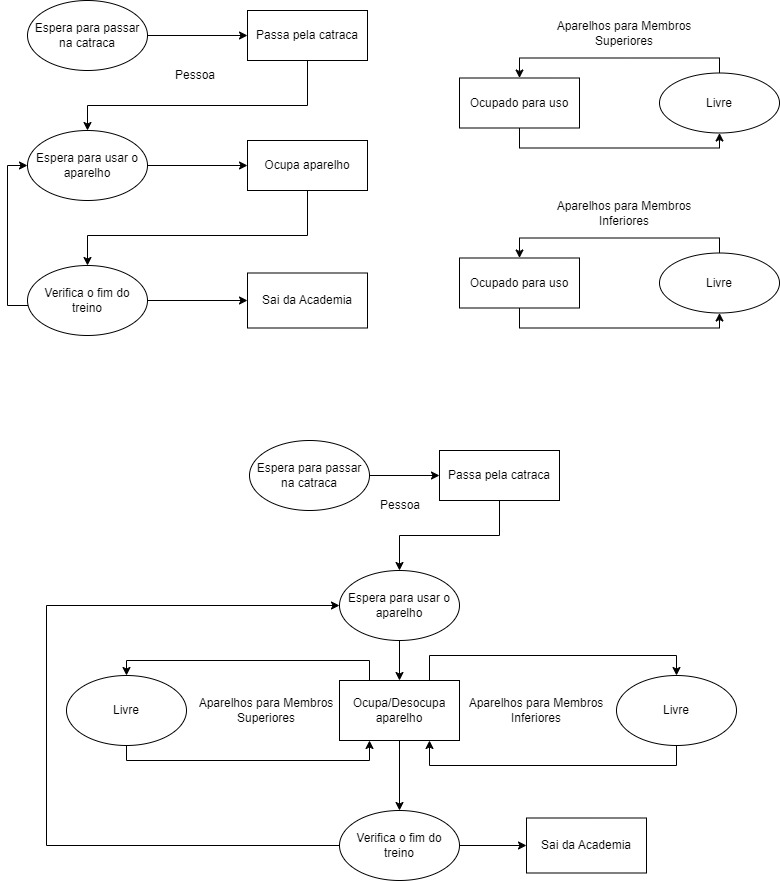

# Lavanderia

### Diagrama

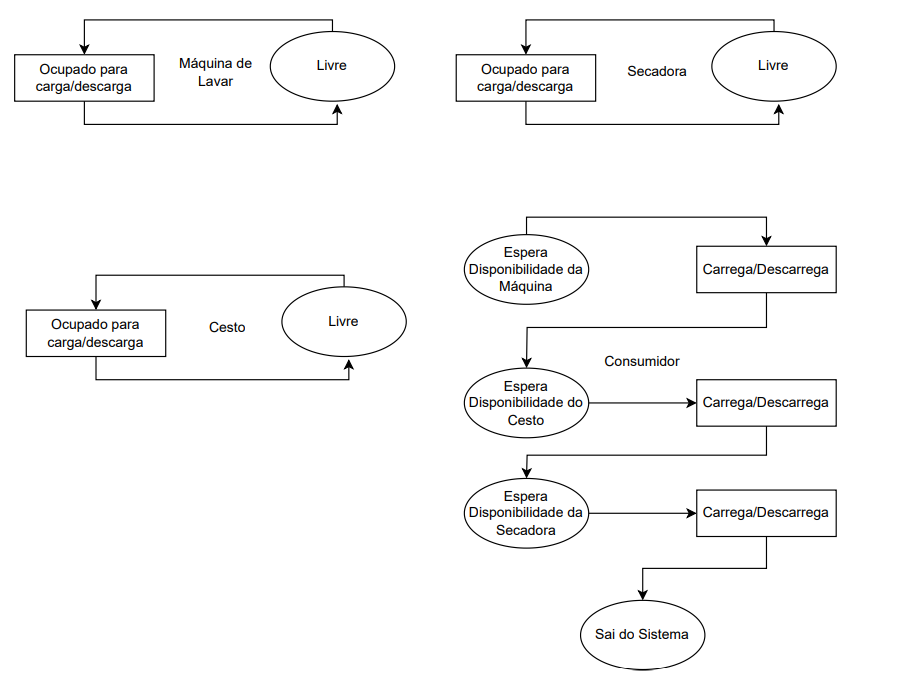

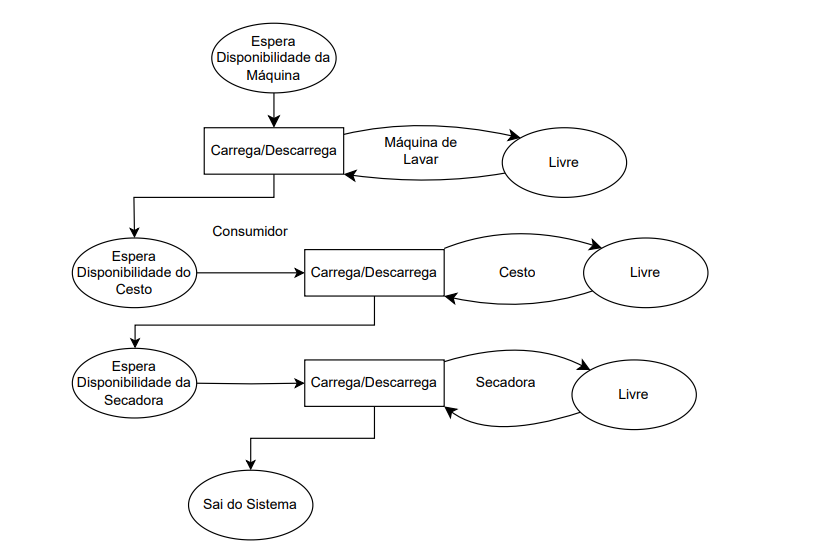

In [73]:
import random

class Pessoa():
    
    def __init__(self, tempo_treino=0) -> None:
        self.treino = []
        self.tempo_treino = tempo_treino

    def montar_treino(self, treinos, quantidade_exercicios):
        for _ in range(quantidade_exercicios):
            self.treino.append(random.choice(list(treinos.keys())))

class Aparelho():
    
    def __init__(self, tipo_aparelho, tempo_ocupado=0) -> None:
        self.tipo_aparelho = tipo_aparelho
        self.tempo_ocupado = tempo_ocupado
    
    def get_tipo(self):
        return self.tipo_aparelho
    
    def get_tempo(self):
        return self.tempo_ocupado
    
    def set_tempo(self, tempo):
        self.tempo_ocupado = tempo

In [75]:
treinos = {0: 'costa', 1: 'bicep', 2: 'peito', 3: 'tricep', 4: 'abdomen', 5: 'perna'}
aparelhos = {}

In [123]:
test = Pessoa()
test.montar_treino(treinos=treinos, quantidade_exercicios=6)
print(test.treino)

[5, 3, 4, 5, 2, 5]


In [60]:
def create_machines(qtd=2):
    for key,value in treinos.items():
        for _ in range(qtd):
            if key not in aparelhos.keys():
                aparelhos[key] = []
            aparelhos[key].append(Aparelho(value))

In [61]:
create_machines()

In [62]:
print(aparelhos)

{0: [<__main__.Aparelho object at 0x0000022198E23D50>, <__main__.Aparelho object at 0x0000022198E22DD0>], 1: [<__main__.Aparelho object at 0x0000022198E21910>, <__main__.Aparelho object at 0x0000022198E20BD0>], 2: [<__main__.Aparelho object at 0x0000022198E21050>, <__main__.Aparelho object at 0x0000022198E22590>], 3: [<__main__.Aparelho object at 0x0000022198E23190>, <__main__.Aparelho object at 0x0000022198E229D0>], 4: [<__main__.Aparelho object at 0x0000022198E23810>, <__main__.Aparelho object at 0x0000022198E22BD0>], 5: [<__main__.Aparelho object at 0x0000022198E235D0>, <__main__.Aparelho object at 0x0000022198E236D0>]}


In [63]:
def print_machines(aparelhos_lst):
    for key, lst_value in aparelhos_lst.items():
        for value in lst_value:
            print(value.get_tipo())
            print(value.get_tempo())

In [64]:
print_machines(aparelhos)

costa
0
costa
0
bicep
0
bicep
0
peito
0
peito
0
tricep
0
tricep
0
abdomen
0
abdomen
0
perna
0
perna
0


Assumindo que cada treino é composto por 

### Código

In [ ]:
import random
import simpy

contaClientes=0             # conta clientes que chegaram no sistema

def distributions(tipo):
    # função que armazena as distribuições utilizadas no modelo
    return {
        'chegadas': random.expovariate(1.0/5.0),
        'lavar': 20,
        'descarregar': random.uniform(1, 4),
        'carregar': 2,
        'secar': random.uniform(9, 12),
    }.get(tipo, 0.0)

def chegadaClientes(env, lavadoras, cestos, secadoras):
    # função que gera a chegada de clientes
    global contaClientes
    while True:
        yield env.timeout(distributions('chegadas'))
        contaPecas += 1
        print(f"Cliente {contaPecas} chega em: {env.now}")
        

    # chamada do processo de lavagem e secagem
        env.process(lavaSeca(env, contaClientes, lavadoras, cestos, secadoras))

def lavaSeca(env, cliente, lavadoras, cestos, secadoras):
    # função que processa a operação de cada cliente dentro da lavanderia
    
    
    # ocupa a lavadora
    req_lavadora = lavadoras.request()
    yield req_lavadora
    print(f'Lavadora inicia a lavagem do Cliente {cliente} as: {env.now}')
    yield env.timeout(distributions('lavar'))
    
    # antes de retirar da lavadora, pega um cesto
    req_cesto = cestos.request()
    yield req_cesto
    print(f'Cliente {cliente} ocupa o cesto as: {env.now}')
    yield env.timeout(distributions('descarregar'))
    

    # libera a lavadora, mas não o cesto
    yield lavadoras.release(req_lavadora)
    print(f'Cliente {cliente} desocupa a lavadora as: {env.now}')

    # ocupa a secadora antes de liberar o cesto
    req_secadora = secadoras.request()
    yield req_secadora
    print(f'Cliente {cliente} ocupa a secadora as: {env.now}')
    yield env.timeout(distributions('carregar'))
    
    # libera o cesto mas não a secadora
    yield cestos.release(req_cesto)
    print(f'Cliente {cliente} desocupa o cesto as: {env.now}')
    yield env.timeout(distributions('secar'))
    
    # pode liberar a secadora
    print(f'Cliente {cliente} iniciar o descarregamento as: {env.now}')
    yield env.timeout(distributions('descarregar'))	
    
    yield secadoras.release(req_secadora)
    print(f'Cliente {cliente} desocupa o secadora as: {env.now}')
    

random.seed(10)
env = simpy.Environment()
lavadoras = simpy.Resource(env, capacity=3)
cestos = simpy.Resource(env, capacity=2)
secadoras = simpy.Resource(env, capacity=1)
env.process(chegadaClientes(env, lavadoras, cestos, secadoras))

env.run(until=40)